In [25]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

img_path = 'Image1.jpg'  # Replace with your image
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [2]:

def process_pixel(img, i, j, k=9, b=25.0, thr=0.8):
    """
    Process one pixel for a color image (H,W,3).
    - img: numpy array float-like, shape (H,W,3)
    - i,j: pixel coordinates
    - k: kernel size (odd)
    - b: intensity-domain sigma
    - thr: threshold on normalized similarity to create binary mask
    Returns a 3-element numpy array (R,G,B) for the reconstructed pixel.
    """
    r = k // 2
    # pad with reflect for color image
    padded = np.pad(img, ((r,r),(r,r),(0,0)), mode='reflect').astype(np.float64)
    pi, pj = i + r, j + r

    # K1: k x k x 3 patch centered at (i,j)
    K1 = padded[pi-r:pi+r+1, pj-r:pj+r+1, :]  # shape (k,k,3)

    # mew: mean of 3x3 neighborhood (including center) around (i,j), per channel
    # handle border automatically due to padding
    mm = padded[pi-1:pi+2, pj-1:pj+2, :]  # shape (3,3,3)
    mew = mm.mean(axis=(0,1))             # shape (3,)

    # a is the mean vector (R,G,B)
    a = mew  # shape (3,)

    # Compute multichannel Gaussian similarity:
    # For each pixel in patch compute squared Euclidean distance in RGB to 'a'
    diff_sq = (K1 - a[None, None, :])**2           # shape (k,k,3)
    dist2 = diff_sq.sum(axis=2)                    # shape (k,k)
    K2 = np.exp(-dist2 / (2.0 * (b**2)))           # shape (k,k), values in (0,1]

    # Min-max normalize K2 -> K3 in [0,1]
    mn = K2.min()
    mx = K2.max()
    K3 = (K2 - mn) / (mx - mn + 1e-12)

    # Threshold to create binary mask K4
    K4 = (K3 >= thr).astype(np.float64)            # shape (k,k)

    wsum = K4.sum()
    # fallback: if empty mask, return original center pixel value
    if wsum == 0:
        return padded[pi, pj, :].astype(np.float64)

    # Weighted mean per channel using binary mask
    # sum over spatial dims, divide by wsum
    weighted = (K4[..., None] * K1).sum(axis=(0,1)) / wsum  # shape (3,)

    return weighted

def reconstruct_image(img, k=9, b=25.0, thr=0.8):
    """
    Reconstruct full image using process_pixel per location.
    - img: input image, shape (H,W,3) or (H,W) for grayscale
    Returns reconstructed image same shape and dtype as input.
    """
    img_arr = img.astype(np.float64)
    if img_arr.ndim == 2:
        # grayscale: adapt single-channel version using same multichannel logic with channel axis 1
        H, W = img_arr.shape
        out = np.zeros((H, W), dtype=np.float64)
        # convert to pseudo-color with single channel for reuse
        img_color = img_arr[:, :, None]
        for i in range(H):
            for j in range(W):
                val = process_pixel(img_color, i, j, k=k, b=b, thr=thr)  # returns length-1 array
                out[i, j] = val[0]
    else:
        H, W, C = img_arr.shape
        assert C == 3, "Expected 3-channel image"
        out = np.zeros_like(img_arr, dtype=np.float64)
        for i in range(H):
            for j in range(W):
                out[i, j, :] = process_pixel(img_arr, i, j, k=k, b=b, thr=thr)

    # clip and cast back to original dtype
    if np.issubdtype(img.dtype, np.integer):
        out = np.clip(out, 0, 255).astype(img.dtype)
    else:
        out = out.astype(img.dtype)
    return out


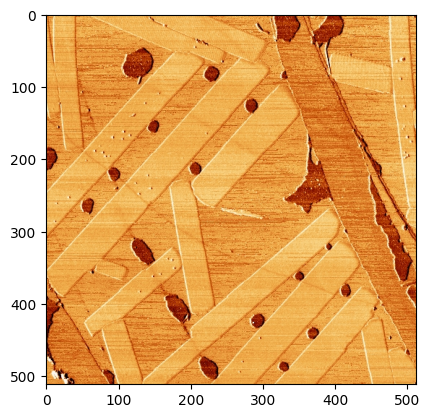

In [3]:
plt.imshow(image)

In [4]:
out = reconstruct_image(image)

KeyboardInterrupt: 

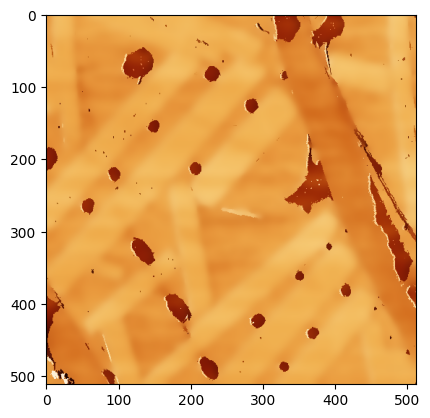

In [15]:
bilateral = cv2.bilateralFilter(bilateral, 9, 50, 50)
plt.imshow(bilateral)

In [21]:
def process_pixel(img, i, j, k=9, b=25.0):
    r = k//2
    padded = np.pad(img, r, mode='constant', constant_values=0)
    pi, pj = i + r, j + r
    K1 = padded[pi-r:pi+r+1, pj-r:pj+r+1].astype(np.float64)
    mew = padded[pi-1:pi+1+1, pj-1:pj+1+1].astype(np.float64)
    mew = (1/9)*(mew.sum())
    a = padded[pi, pj]
    a = mew
    K2 = np.exp(-((K1 - a)**2) / (2.0 * (b**2)))
    mn = K2.min()
    mx = K2.max()
    K3 = (K2 - mn) / (mx - mn + 1e-12)
    K4 = (K3 >= 0.8).astype(np.float64)
    wsum = K4.sum()
    if wsum == 0:
        return float(a)
    patch = K1
    return float((K4 * patch).sum() / wsum)

def reconstruct_image(img, k=9, b=25.0):
    img_arr = img.astype(np.float64)
    H, W = img_arr.shape
    out = np.zeros_like(img_arr)
    for i in range(H):
        for j in range(W):
            out[i, j] = process_pixel(img_arr, i, j, k=k, b=b)
    return out


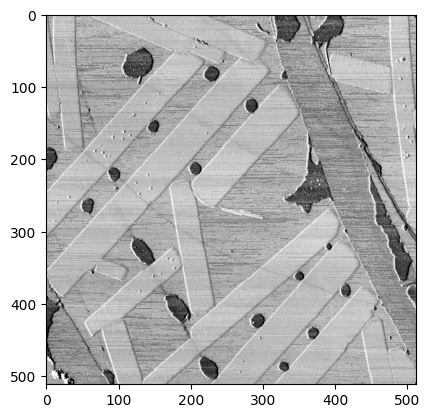

In [27]:
img = cv2.imread('Image1.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap = "gray")

In [23]:
im2 = reconstruct_image(img,9,50)
plt.imshow(im2, cmap = "gray")

KeyboardInterrupt: 

In [24]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

def box_filter_mean_per_channel(img, window=3):
    """Compute per-channel box filter mean using integral image (reflect padding).
    img: (H,W,3) float array. Returns (H,W,3) mean over window centered.
    """
    H, W, C = img.shape
    r = window // 2
    padded = np.pad(img, ((r,r),(r,r),(0,0)), mode='reflect').astype(np.float64)
    S = padded.cumsum(axis=0).cumsum(axis=1)  # integral image
    # indices for top-left corners
    x1 = np.arange(0, H)
    y1 = np.arange(0, W)
    X1, Y1 = np.meshgrid(x1, y1, indexing='ij')
    X2, Y2 = X1 + window - 1, Y1 + window - 1
    A = S[X2, Y2]
    B = S[np.clip(X1-1, -1, S.shape[0]-1), Y2]
    Cc = S[X2, np.clip(Y1-1, -1, S.shape[1]-1)]
    D = S[np.clip(X1-1, -1, S.shape[0]-1), np.clip(Y1-1, -1, S.shape[1]-1)]
    # correct for -1 indices which should be treated as zero
    mask_x = (X1-1) >= 0
    mask_y = (Y1-1) >= 0
    B = np.where(mask_x[..., None], B, 0.0)
    Cc = np.where(mask_y[..., None], Cc, 0.0)
    D = np.where((mask_x & mask_y)[..., None], D, 0.0)
    sums = A - B - Cc + D
    return sums / (window*window)

def reconstruct_image_vectorized(img, k=9, b=25.0, thr=0.8):
    """
    Vectorized reconstruction for color image.
    img: HxWx3 numpy array (uint8 or float). Returns same dtype as input.
    k: kernel size (odd)
    b: intensity-domain sigma
    thr: threshold on normalized similarity
    """
    img_f = img.astype(np.float64)
    H, W, C = img_f.shape
    r = k//2

    # Compute 3x3 per-channel mean (mew)
    mew = box_filter_mean_per_channel(img_f, window=3)  # (H,W,3)

    # Extract patches: use sliding_window_view on first two axes, keep channels
    pad = np.pad(img_f, ((r,r),(r,r),(0,0)), mode='reflect')
    patches = sliding_window_view(pad, (k, k, C))  # shape (H, W, k, k, C)

    # Compute squared distance per patch to mew
    mew_exp = mew[:, :, None, None, :]  # (H,W,1,1,3)
    diff_sq = (patches - mew_exp)**2
    dist2 = diff_sq.sum(axis=4)  # (H,W,k,k)

    K2 = np.exp(-dist2 / (2.0 * (b**2)))
    K2_flat = K2.reshape(H, W, -1)
    mn = K2_flat.min(axis=2, keepdims=True)
    mx = K2_flat.max(axis=2, keepdims=True)
    K3_flat = (K2_flat - mn) / (mx - mn + 1e-12)
    K3 = K3_flat.reshape(H, W, k, k)
    K4 = (K3 >= thr).astype(np.float64)  # (H,W,k,k)

    K4_exp = K4[..., None]  # (H,W,k,k,1)
    weighted = (K4_exp * patches).sum(axis=(2,3))  # (H,W,3)
    wsum = K4.sum(axis=(2,3))  # (H,W)
    wsum_safe = wsum.copy()
    wsum_safe[wsum_safe == 0] = 1.0
    out = weighted / wsum_safe[..., None]
    centers = img_f
    zero_mask = (wsum == 0)
    out[zero_mask] = centers[zero_mask]
    if np.issubdtype(img.dtype, np.integer):
        out = np.clip(out, 0, 255).astype(img.dtype)
    else:
        out = out.astype(img.dtype)
    return out

# Expose the function for user
print("Vectorized function 'reconstruct_image_vectorized(img, k=9, b=25.0, thr=0.8)' is ready.")


Vectorized function 'reconstruct_image_vectorized(img, k=9, b=25.0, thr=0.8)' is ready.


In [28]:
out = reconstruct_image_vectorized(img)

ValueError: not enough values to unpack (expected 3, got 2)